In [27]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
# connect to the database
conn = sqlite3.connect('../max-experiments/itinerary-scraping/journeys.db')
cursor = conn.cursor()

# get all outages
cursor.execute('SELECT * FROM outages')
outages = cursor.fetchall()
# outages

In [29]:
cursor.execute('SELECT * FROM outages')
outages = cursor.fetchall()

cursor.execute('SELECT * FROM journeys')
journeys = cursor.fetchall()

# number of outages
print(len(outages))

print('---')
print("% of journeys with outages:", round(len(outages)/len(journeys) * 100, 3))

183
---
% of journeys with outages: 0.104


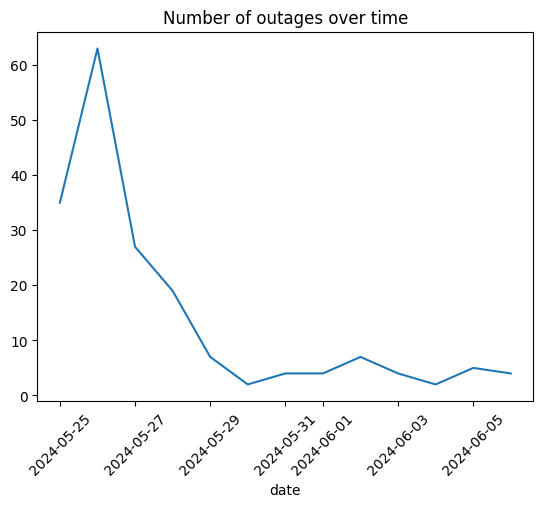

In [30]:
outages_df = pd.DataFrame(outages, columns=['outage_id', 'stop_id', 'effect', 'updated_at', 'outage_data'])

outages_df['updated_at'] = pd.to_datetime(outages_df['updated_at'])
outages_df['date'] = outages_df['updated_at'].dt.date

# plot number of outages over time
outages_df.groupby('date').size().plot()
plt.title('Number of outages over time')
# rotate x-axis labels
plt.xticks(rotation=45)
plt.show()


In [31]:
# average length of outages
durations = []
for row in outages_df['outage_data']:
    row = row.split('begin')[1]
    
    # format is now ": "20240525T000000", "end": "20240525T193000"}]}
    # we want to extract the two dates and calculate the difference
    row = row[4:]   # cut off the first ": "
    
    # begin is the next 15 characters
    begin = row[:15]
    row = row[26:]      # cut to the end date
    
    # end is the next 15 characters
    end = row[:15]
    
    # calculate the difference
    begin = pd.to_datetime(begin)
    end = pd.to_datetime(end)
    
    # convert to seconds
    duration = (end - begin).total_seconds()
    durations.append(duration)
    
print('Average outage duration:', round(sum(durations)/len(durations), 3), 'seconds')
print('Median outage duration:', pd.Series(durations).median(), 'seconds')
print('----------')

q1 = pd.Series(durations).quantile(0.25)
q3 = pd.Series(durations).quantile(0.75)
iqr = q3 - q1

# remove outliers
durations_no_outliers = [duration for duration in durations if duration < q3 + 1.5*iqr]
print('Average outage duration (no outliers):', round(sum(durations_no_outliers)/len(durations_no_outliers), 3), 'seconds')
print('Median outage duration (no outliers):', pd.Series(durations_no_outliers).median(), 'seconds')

outages_df['duration'] = durations # add duration to the dataframe

Average outage duration: 469131.148 seconds
Median outage duration: 30600.0 seconds
----------
Average outage duration (no outliers): 42197.605 seconds
Median outage duration (no outliers): 27000.0 seconds


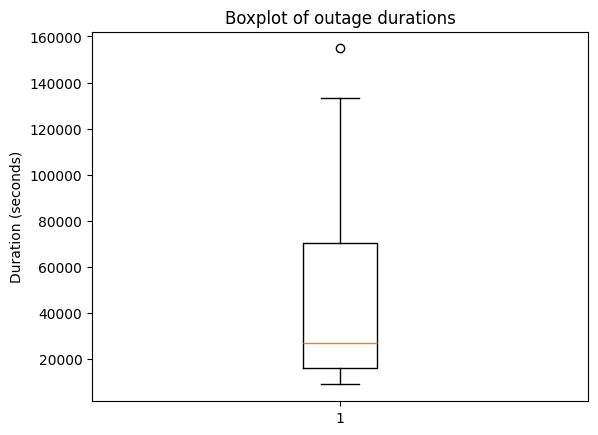

In [32]:
# boxplot of outage durations
plt.boxplot(durations_no_outliers)
plt.title('Boxplot of outage durations')
plt.ylabel('Duration (seconds)')
plt.show()

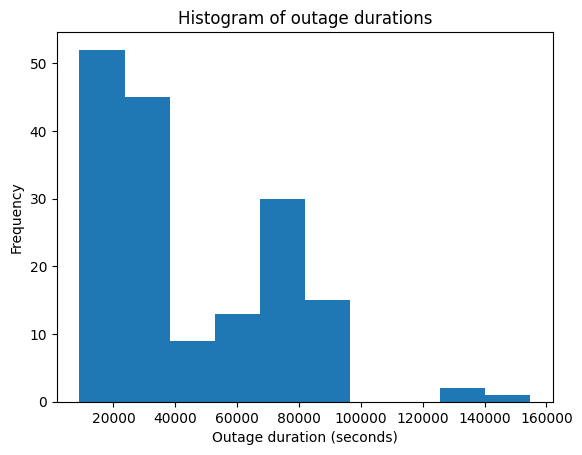

In [33]:
# histogram of outage durations
pd.Series(durations_no_outliers).hist(bins=10)
plt.title('Histogram of outage durations')
plt.xlabel('Outage duration (seconds)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

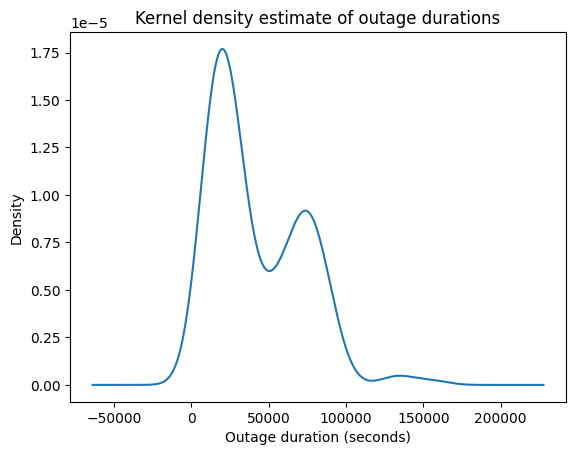

In [34]:
# Kernel density estimate of outage durations
pd.Series(durations_no_outliers).plot.kde()
plt.title('Kernel density estimate of outage durations')
plt.xlabel('Outage duration (seconds)')
plt.ylabel('Density')
plt.grid(False)
plt.show()

In [35]:
# frequency of outages
from collections import Counter
outage_freq = Counter([outage[1] for outage in outages])
print(outage_freq)

# get the stop names
cursor.execute('SELECT * FROM stops')
stops = cursor.fetchall()

stop_names = {}
for stop in stops:
    stop_names[stop[0]] = stop[1]
    
# get the most frequent outages
most_frequent_outages = sorted(outage_freq.items(), key=lambda x: x[1], reverse=True)
# print(most_frequent_outages)
# for stop_id, freq in most_frequent_outages:
#     print(stop_names[stop_id], freq)


Counter({'stop_point:tcl:SP:46024': 8, 'stop_point:tcl:SP:30205': 5, 'stop_point:tcl:SP:46051': 5, 'stop_point:tcl:SP:46033': 5, 'stop_point:tcl:SP:46036': 4, 'stop_point:tcl:SP:48137': 4, 'stop_point:tcl:SP:30209': 4, 'stop_point:tcl:SP:30189': 4, 'stop_point:tcl:SP:30197': 4, 'stop_point:tcl:SP:46058': 4, 'stop_point:tcl:SP:30445': 4, 'stop_point:tcl:SP:30211': 4, 'stop_point:tcl:SP:30156': 3, 'stop_point:tcl:SP:46053': 3, 'stop_point:tcl:SP:46054': 3, 'stop_point:tcl:SP:46026': 3, 'stop_point:tcl:SP:46028': 3, 'stop_point:tcl:SP:30448': 3, 'stop_point:tcl:SP:30198': 3, 'stop_point:tcl:SP:30200': 3, 'stop_point:tcl:SP:30208': 3, 'stop_point:tcl:SP:46060': 3, 'stop_point:tcl:SP:46025': 3, 'stop_point:tcl:SP:42744': 3, 'stop_point:tcl:SP:42738': 3, 'stop_point:tcl:SP:30185': 3, 'stop_point:tcl:SP:36394': 3, 'stop_point:tcl:SP:30191': 3, 'stop_point:tcl:SP:30199': 3, 'stop_point:tcl:SP:30103': 3, 'stop_point:tcl:SP:30447': 3, 'stop_point:tcl:SP:30210': 3, 'stop_point:tcl:SP:46031': 2, '

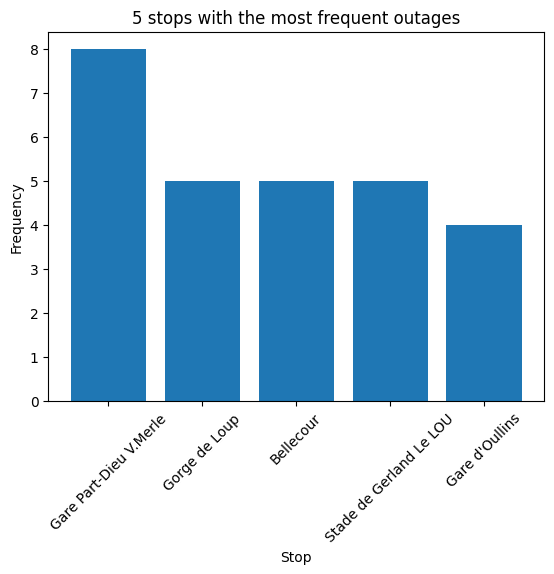

In [36]:
# Plot the 5 stops with the most frequent outages
top_5 = most_frequent_outages[:5]
top_5_names = [stop_names[stop_id] for stop_id, freq in top_5]
top_5_freq = [freq for stop_id, freq in top_5]

plt.bar(top_5_names, top_5_freq)
plt.title('5 stops with the most frequent outages')
plt.xlabel('Stop')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

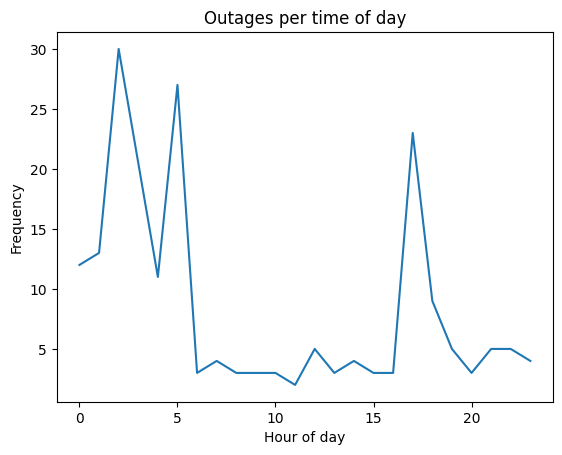

In [37]:
# plot outages per time of day
outages_df['hour'] = outages_df['updated_at'].dt.hour
outages_df.groupby('hour').size().plot()
plt.title('Outages per time of day')
plt.xlabel('Hour of day')
plt.ylabel('Frequency')
plt.show()


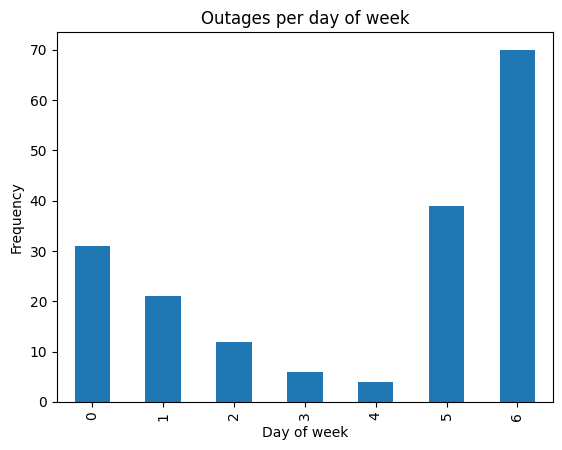

In [38]:
# barplot outages per day of week
outages_df['day_of_week'] = outages_df['updated_at'].dt.dayofweek
outages_df.groupby('day_of_week').size().plot(kind='bar')
plt.title('Outages per day of week')
plt.xlabel('Day of week')
plt.ylabel('Frequency')
plt.show()

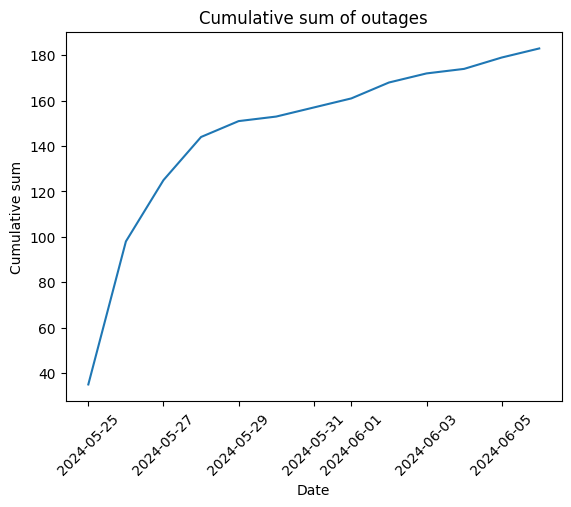

In [39]:
# cumulative sum plot of outages
outages_df.groupby('date').size().cumsum().plot()
plt.title('Cumulative sum of outages')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Cumulative sum')
plt.show()

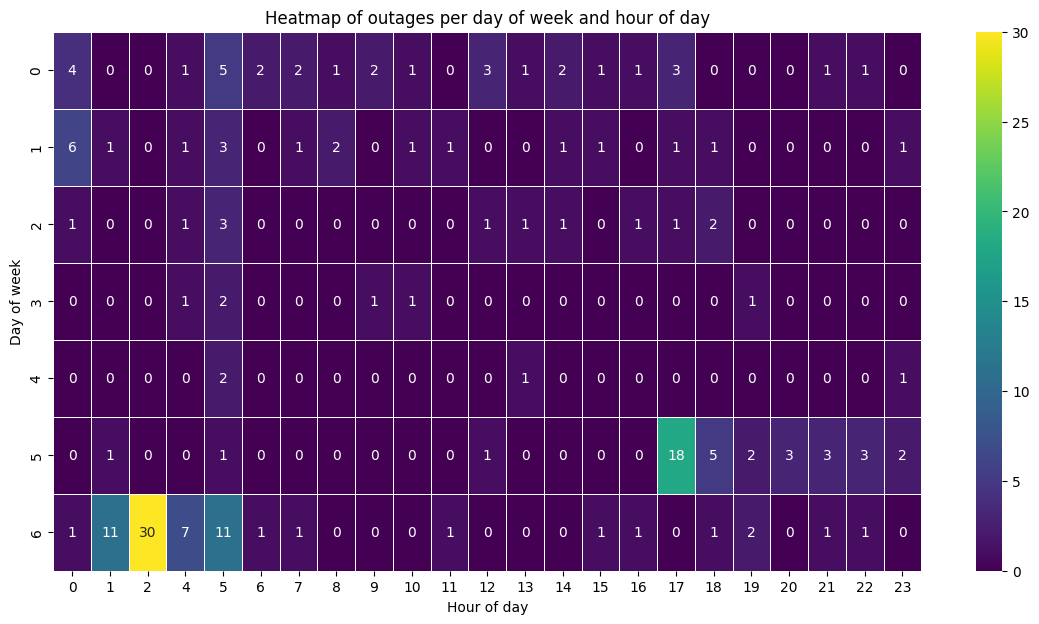

In [59]:
import seaborn as sns
# 2D heatmap of outages per day of week and hour of day
heatmap_data = outages_df.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)

# reorder the days of the week
heatmap_data = heatmap_data.reindex(index=[0, 1, 2, 3, 4, 5, 6])

# plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d', linewidths=0.5)
plt.title('Heatmap of outages per day of week and hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Day of week')

# popup on cell click with the frequency by station
def on_click(event):
    day = event.ydata
    hour = event.xdata
    print('Day:', day, 'Hour:', hour)
    print(outages_df[(outages_df['day_of_week'] == day) & (outages_df['hour'] == hour)]['stop_id'].value_counts())
    
plt.gcf().canvas.mpl_connect('button_press_event', on_click)
plt.show()

<Axes: xlabel='label'>

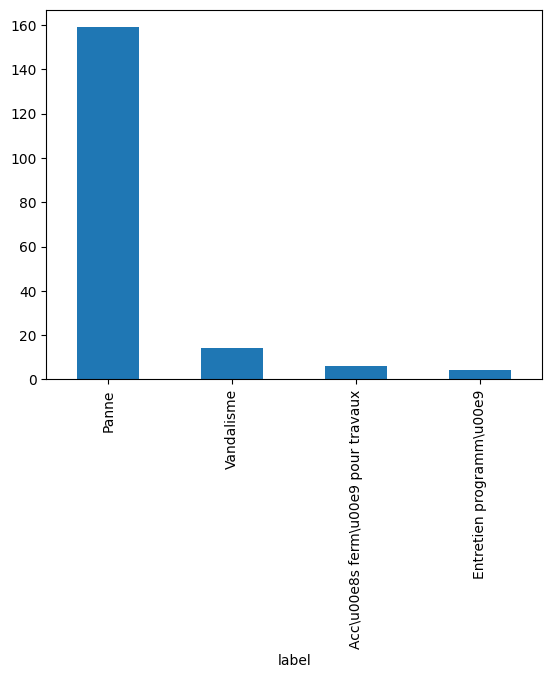

In [58]:
outages_df['outage_data'][1]
outages_df['label'] = outages_df['outage_data'].apply(lambda x: x.split('label')[1].split('"')[2])

# barchart of most frequent labels
outages_df.groupby('label').size().sort_values(ascending=False).plot(kind='bar')

In [45]:
cursor.execute('SELECT * FROM stops')
stops = cursor.fetchall()
stops_df = pd.DataFrame(stops, columns=['stop_id', 'stop_name', 'stop_coords', 'stop_accessibility'])

In [46]:
# merge the outages dataframe with the stops dataframe
merged_df = pd.merge(outages_df, stops_df, on='stop_id')
merged_df

,outage_id,stop_id,effect,updated_at,outage_data,date,duration,hour,day_of_week,stop_name,stop_coords,stop_accessibility
0,828,stop_point:tcl:SP:30205,unavailable,2024-05-25 17:28:00+02:00,"{""cause"": {""label"": ""Acc\u00e8s ferm\u00e9 pou...",2024-05-25,70200.0,17,5,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
1,8201,stop_point:tcl:SP:30205,unavailable,2024-05-26 05:33:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-26,27000.0,5,6,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
2,822,stop_point:tcl:SP:30205,unavailable,2024-05-29 05:08:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-29,27000.0,5,2,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
3,8202,stop_point:tcl:SP:30205,unavailable,2024-06-04 05:08:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-06-04,27000.0,5,1,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
4,8203,stop_point:tcl:SP:30205,unavailable,2024-06-04 08:38:00+02:00,"{""cause"": {""label"": ""Vandalisme""}, ""effect"": {...",2024-06-04,37800.0,8,1,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
...,...,...,...,...,...,...,...,...,...,...,...,...
178,7301,stop_point:tcl:SP:30187,unavailable,2024-05-29 17:53:00+02:00,"{""cause"": {""label"": ""Vandalisme""}, ""effect"": {...",2024-05-29,72000.0,17,2,Laennec,"{""lon"": ""4.886328"", ""lat"": ""45.738716""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
179,241,stop_point:tcl:SP:42743,unavailable,2024-05-31 05:08:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-31,25200.0,5,4,Hôtel de Ville L. Pradel,"{""lon"": ""4.836091"", ""lat"": ""45.767309""}","[""has_wheelchair_boarding""]"
180,7601,stop_point:tcl:SP:30194,unavailable,2024-05-31 05:18:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-31,27000.0,5,4,Sans Souci,"{""lon"": ""4.864748"", ""lat"": ""45.747747""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
181,761,stop_point:tcl:SP:30194,unavailable,2024-06-02 02:28:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-06-02,16200.0,2,6,Sans Souci,"{""lon"": ""4.864748"", ""lat"": ""45.747747""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
